In [1]:
#import necessary library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
import category_encoders as ce
from category_encoders import OrdinalEncoder

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb



# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


In [2]:
# define dataframe as df_ML we use resamples dataset from previous EDA

df_ML = pd.read_excel('bank-additional-samples.xlsx')
pd.set_option('display.max_columns', None)
df_ML.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,deposit,age_group
0,18,student,single,high.school,no,no,no,telephone,nov,thu,75,1,-1,0,nonexistent,-0.1,93200,-42.0,5195.8,0,"(17.0, 25.0]"
1,18,student,single,high.school,no,yes,yes,cellular,mar,tue,103,1,-1,0,nonexistent,-1.8,92843,-50.0,5099.1,0,"(17.0, 25.0]"
2,19,student,single,basic.9y,no,yes,no,cellular,may,tue,203,1,-1,3,failure,-1.8,93876,-40.0,5008.7,0,"(17.0, 25.0]"
3,19,student,single,basic.9y,no,no,no,cellular,aug,mon,96,1,3,1,success,-2.9,92201,-31.4,5076.2,0,"(17.0, 25.0]"
4,19,student,single,unknown,no,no,no,cellular,apr,fri,108,5,-1,0,nonexistent,-1.8,93075,-47.1,5099.1,0,"(17.0, 25.0]"


# 3.1 Data Preprocessing
Data preprocessing in machine learning is a series of steps undertaken for cleaning data, transforming data, separating features and target/labels, and organizing raw data to make it more suitable for use in creating machine learning models. The goal of data preprocessing is to enhance the quality of data, reduce noise, address missing values issues, and make the data more easily interpretable by machine learning algorithms.

- Based on our EDA before, we don't need age_group for our modelling because that column is for EDA purpose only, also the column of 'loan' has not statistically significance influence to our target, therefore we will drop thise two column

In [3]:
# remove column from EDA analysis
df_ML.drop(columns='age_group',inplace=True)
df_ML.drop(columns='loan',inplace=True)

In [4]:
df_ML.duplicated().sum()

0

In [5]:
#checking the dataset information
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9282 entries, 0 to 9281
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             9282 non-null   int64  
 1   job             9282 non-null   object 
 2   marital         9282 non-null   object 
 3   education       9282 non-null   object 
 4   default         9282 non-null   object 
 5   housing         9282 non-null   object 
 6   contact         9282 non-null   object 
 7   month           9282 non-null   object 
 8   day_of_week     9282 non-null   object 
 9   duration        9282 non-null   int64  
 10  campaign        9282 non-null   int64  
 11  pdays           9282 non-null   int64  
 12  previous        9282 non-null   int64  
 13  poutcome        9282 non-null   object 
 14  emp.var.rate    9282 non-null   float64
 15  cons.price.idx  9282 non-null   int64  
 16  cons.conf.idx   9282 non-null   float64
 17  nr.employed     9282 non-null   f

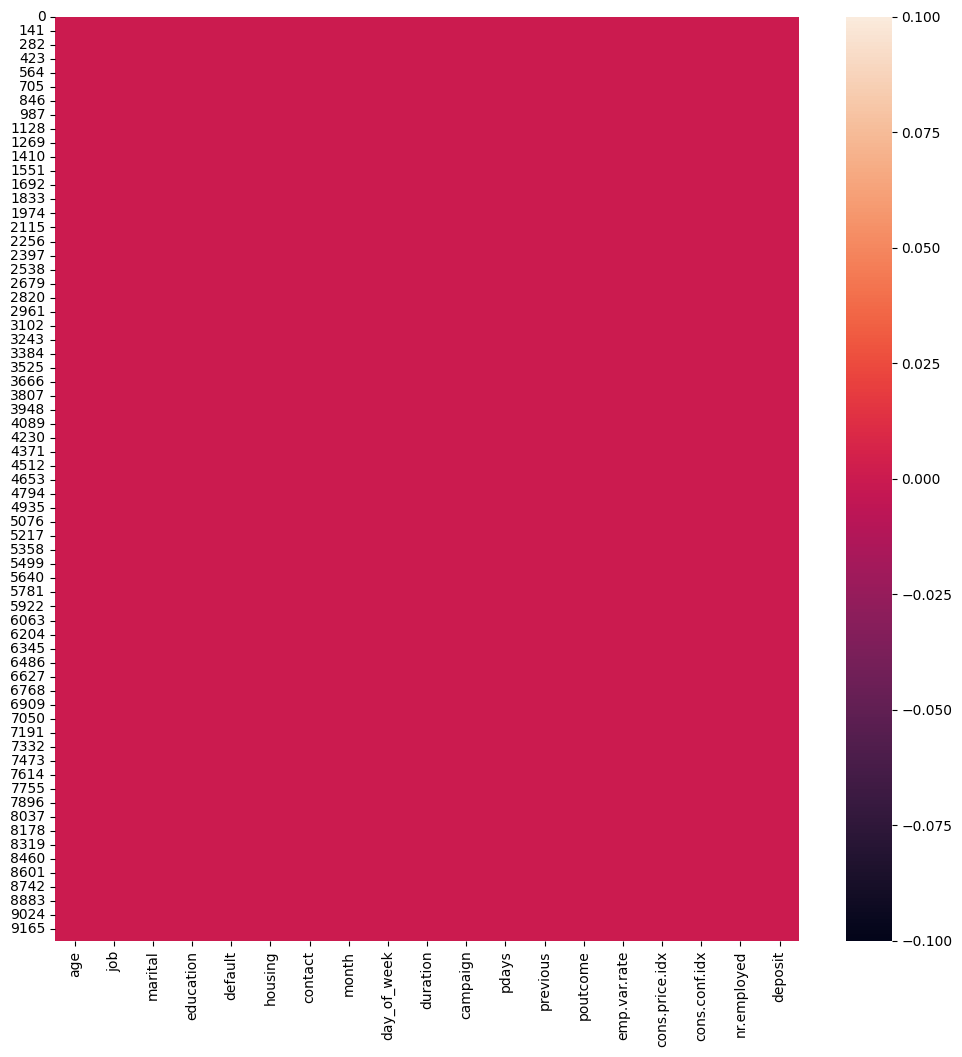

In [6]:
# Visualize the missing value

column_names = df_ML.columns.tolist()

plt.figure(figsize=(12,12))
sns.heatmap(df_ML[column_names].isna());

As mentioned earlier in data cleaning and from source documentation, 'Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques'.  

Therefore we will conduct to treat unknown as missing value for our modelling 

In [7]:
# Finding which column has unknown value
unknown_finders = df_ML.apply(lambda x: x.value_counts().get('unknown', 0))
(unknown_finders[unknown_finders > 0])

job            72
marital        23
education     459
default      1530
housing       213
dtype: int64

There are 5 columns that has unknown value, and all of those are categorical features. Therefore, we will fill the unknown column using NaN in order to treat similarly as missing values.
From visualisation, those 5 columns have missing value now. We must impute or fill missing value in order to optimize our model, maintain data integrity and avoid biased analyisis. There are several methods to impute missing value as follows:

- Simple imputer by mean or median for numerical column, mean if the data is distributed normal, while median for data that has outliers.
- Simple imputer by mode for replacing missing value by most frequent value that is mentioned on that column.
- Imperative imputer for numerical column, predict and fill missing value toward relation between other variables.
- KNN imputer, calculates the distance between data points and uses the values from the nearest neighbors to impute missing values.
- Domain knowledge imputation, filling missing value with domain expertise
- Multiple imputation, impute missing value with different imputed values.

For our imputation, we will handle missing value with our domain knowledge imputation, which derived from our EDA. Since those 5 column has statistically significance influence toward target, then we leave the table as unknown but replace it with 'other' instead. Because if we stick to the 'unknown' value on categorical, our modelling handle it differently.  

### 3.1.1 Handling unknown/missing value on job column

In [8]:
# using 'other' to replace unknown value for those 6 columns
df_ML['job'] = df_ML['job'].replace('unknown', 'other')
df_ML['marital'] = df_ML['marital'].replace('unknown', 'other')
df_ML['education'] = df_ML['education'].replace('unknown', 'other')
df_ML['default'] = df_ML['default'].replace('unknown', 'other')
df_ML['housing'] = df_ML['housing'].replace('unknown', 'other')

## 3.2 Data Splitting

In data splitting, we will split the data into train and test set, The training set is used for training the model, and the testing set is used to test our model. Also we will conduct transformer or column transformer which can apply different transformations to different subsets of our data. We also need to encode our string value into numeric because in this case, machine learning only take on numerical data. Also we need to scaling the numeric because each column has different scale or digits that need to treated as consistently. It ensures that the machine learning model is not disproportionately influenced by variables with larger numeric ranges, promoting fair and effective learning across all features.

In [9]:
# Feature dan Target
X = df_ML.drop(columns=['deposit'])
y = df_ML['deposit']

In [10]:
# Train test split our data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

For the transfomer, there are two types that we want to transform our data for our modelling.
- Encode, To make our string value as numeric, There are certain method which is one_hot_encode or binary_encode to transform nominal value into numeric, and also there is ordinal_encode to transform value that based on 'rank' to th numerical value
- Scaling, we need to scale to ensure consistent proportion between our numerical value. There are standard scaler (each feature is scaled by subtracting the mean and dividing by the standard deviation) but sensitive to outliers. The other method is Robust Scaler which is each feature is scaled using the median and the interquartile range (IQR). 

For our model and transformer, we will use binary encode for education feature, because we assume education is a hierarchy level of people. And the rest of string feature, we will use one_hot. For scaling we will use robust_scaler since we have outliers as mentioned from previously on our EDA.

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 6899 to 1691
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             6497 non-null   int64  
 1   job             6497 non-null   object 
 2   marital         6497 non-null   object 
 3   education       6497 non-null   object 
 4   default         6497 non-null   object 
 5   housing         6497 non-null   object 
 6   contact         6497 non-null   object 
 7   month           6497 non-null   object 
 8   day_of_week     6497 non-null   object 
 9   duration        6497 non-null   int64  
 10  campaign        6497 non-null   int64  
 11  pdays           6497 non-null   int64  
 12  previous        6497 non-null   int64  
 13  poutcome        6497 non-null   object 
 14  emp.var.rate    6497 non-null   float64
 15  cons.price.idx  6497 non-null   int64  
 16  cons.conf.idx   6497 non-null   float64
 17  nr.employed     6497 non-null 

In [12]:
#Transformer
numeric_transformer = Pipeline([
    ('scaler', RobustScaler()) #Robust scaler because not sensitive to outliers
])

ordinal_mapping = [
    {'col':'education', 'mapping':{'illiterate':1, 'basic.4y':2, 'basic.6y':3, 'basic.9y':4, 'high.school':5, 'professional.course':6, 'university.degree':7}} #making rank or hierarchy on education feature
]

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first')) #encode the rest of str feature
])

# doing transformation
transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(cols=['education'], mapping=ordinal_mapping), ['education']),
    ('numeric', numeric_transformer, ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed','duration']),
    ('categorical', categorical_transformer, ['job', 'marital','default','housing','contact','month','day_of_week','poutcome'])
], remainder='passthrough')

In [13]:
transformer.fit(X_train) #fit our train data into transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['education'],
                                                mapping=[{'col': 'education',
                                                          'data_type': dtype('O'),
                                                          'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
professional.course    6
university.degree      7
dtype: int64}]),
                                 ['education']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'nr.employed', 'duration']),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['job', 'marital', 'default', 'housing',
                                  'contact', 'month', 'day_of_week',
                                  'poutcome'])])

## 3.3 Model benchmarking

In this phase, we will conduct model benchmarking using various classification models, including:

- Logistic Regression: Prediction based on the linear relationship between input features and the probability of an event occurring for a class.
- Decision Tree: Selection of the most important features at each step to predict a decision.
- Random Forest: An ensemble algorithm consisting of a number of decision trees (decisions) generated randomly to reduce overfitting (excessive complexity).
- KNN (K-Nearest Neighbors): Identification of the majority class among neighbors (closest data points) of the point to be predicted.
- Gradient Boosting: Operates by building a series of weak learners, typically decision trees, sequentially. Each tree corrects the errors made by the preceding ones, optimizing the overall predictive performance.
- XG Boost: A popular ensemble algorithm that combines a large number of previously optimized decision trees. Compared to Gradient Boosting, XG boost has build-in regularization on that.
- Catboost: Similar concept like Gradient Boosting, developen by Yandex, it automated a lot of process from Gradient Boosting in order ti perform efficiently.

In [14]:
# Define 7 models that we have chosen for classification modelling.
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state = 42)
gb = GradientBoostingClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42)



#Defineestimator for models
estimators = [
    ('tree', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('logreg', LogisticRegression(random_state=42)),
    ('random forest', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('cat', CatBoostClassifier(random_state=42))
]


# Name of models
models = {'KNN': knn, 
          'Logistic Regression':logreg, 
          'Decision Tree': tree,
          'xg boost': xgb,  
          'random forest':rf,
          'gradient boosting':gb,
          'catboost':cat
          }



# pName of metrics
f2_score = make_scorer(fbeta_score, beta=2)
metrics = {'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'f2': f2_score}

#variabel to store our result  
test_accuracy_arr = []    
test_precision_arr = []
test_recall_arr = []
test_f1_arr = []
test_f2_arr = []
list_algo = []
list_resample = []

#looping for our model benchmarking
for name_algo,model in models.items():
    crossval = StratifiedKFold(n_splits=5) #5 times validation, stratisfieldKfold used because classification label

    estimator = Pipeline([
        ('transform', transformer),
        ('model', model),
    ])

    scores = cross_validate(estimator,X_train,y_train,cv=crossval, scoring=metrics)
    
    list_algo.append(name_algo)
    test_accuracy_arr.append(scores['test_balanced_accuracy'].mean()) 
    test_precision_arr.append(scores['test_precision'].mean())
    test_recall_arr.append(scores['test_recall'].mean())
    test_f1_arr.append(scores['test_f1'].mean())
    test_f2_arr.append(scores['test_f2'].mean())

# Turn to dataframe
model_bench = pd.DataFrame({
    'model': list_algo,
    'accuracy': test_accuracy_arr,
    'precision': test_precision_arr,
    'recall': test_recall_arr,
    'f1': test_f1_arr,
    'f2': test_f2_arr
})

model_bench

Learning rate set to 0.020824
0:	learn: 0.6718928	total: 125ms	remaining: 2m 4s
1:	learn: 0.6518022	total: 132ms	remaining: 1m 5s
2:	learn: 0.6347380	total: 141ms	remaining: 46.8s
3:	learn: 0.6169871	total: 151ms	remaining: 37.6s
4:	learn: 0.6001988	total: 160ms	remaining: 31.8s
5:	learn: 0.5848395	total: 168ms	remaining: 27.9s
6:	learn: 0.5688165	total: 179ms	remaining: 25.4s
7:	learn: 0.5557170	total: 190ms	remaining: 23.5s
8:	learn: 0.5423231	total: 197ms	remaining: 21.7s
9:	learn: 0.5300371	total: 208ms	remaining: 20.6s
10:	learn: 0.5194281	total: 215ms	remaining: 19.3s
11:	learn: 0.5082535	total: 223ms	remaining: 18.3s
12:	learn: 0.4973893	total: 229ms	remaining: 17.4s
13:	learn: 0.4891910	total: 236ms	remaining: 16.6s
14:	learn: 0.4806346	total: 243ms	remaining: 15.9s
15:	learn: 0.4712504	total: 248ms	remaining: 15.2s
16:	learn: 0.4621237	total: 254ms	remaining: 14.7s
17:	learn: 0.4562546	total: 259ms	remaining: 14.1s
18:	learn: 0.4482391	total: 263ms	remaining: 13.6s
19:	learn: 

,model,accuracy,precision,recall,f1,f2
0,KNN,0.846852,0.848828,0.843858,0.846326,0.844841
1,Logistic Regression,0.872715,0.862517,0.886969,0.874461,0.881896
2,Decision Tree,0.828073,0.828768,0.827224,0.827870,0.827452
3,xg boost,0.879498,0.859269,0.907611,0.882715,0.897470
4,random forest,0.882734,0.854583,0.922391,0.887126,0.907936
5,gradient boosting,0.887815,0.856474,0.931630,0.892454,0.915549
6,catboost,0.889507,0.861870,0.927629,0.893489,0.913651


In [15]:
#sort by precision, the metric we choose
model_bench_sort = model_bench.sort_values(by='precision',ascending=False)
model_bench_sort.head()


,model,accuracy,precision,recall,f1,f2
1,Logistic Regression,0.872715,0.862517,0.886969,0.874461,0.881896
6,catboost,0.889507,0.861870,0.927629,0.893489,0.913651
3,xg boost,0.879498,0.859269,0.907611,0.882715,0.897470
5,gradient boosting,0.887815,0.856474,0.931630,0.892454,0.915549
4,random forest,0.882734,0.854583,0.922391,0.887126,0.907936


We get the result that from our train sample data, logistic regression has the highest value, precision is 0.861745 which considered as high and acceptable for our training data. Then, we see other metric as well as comparison, all different metric have good score as well, this mean that  generally indicates  the models are performing well across multiple evaluation criteria. If one of the metric has lower score either is precision or other metric, it may indicates our model or even our data is not performing well and need to be recheck back or using feature selection. But that condition do not happen here. The reason is because we carefully sample and clean our original dataset. Therefore, it safe to continue to test our model into testing dataset. 

## 3.4 Predict to Test Set

If in 3.3 Model benchmarking, we already search our best model based on Train data, now we must implement our model to our test data. Before that we breakdown the proportion of training data 70% toward 30% of testing data. After the result of our test data later on, we must consider the result as follows:
- Is the data Overfitting or Underfitting, this means if our train data has exact score but the result from the test data highly inflated, then we're doing underfit in our model. If our train data has high score but the testing data way below that, then we are underfit. If that happen, then our data and model is not optimal.
- Second, we must check multi-score from other metric. If our chosen metric has highly differs between other metric, it can be stated that our model is bias.

For that two conditions above, we will check after testing result.

In [16]:
# Logreg as our best model from train data
logreg = LogisticRegression(random_state=42)

# Initialize lists for etrics
score_accuracy = []
score_precision = []
score_recall = []
score_f1 = []
score_f2 = []

# Create a Pipeline
model = Pipeline([
    ('transform', transformer),
    ('model', logreg)
])

# Fit and Evaluate the Model    
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score_accuracy.append(accuracy_score(y_test, y_pred))
score_precision.append(precision_score(y_test, y_pred))
score_recall.append(recall_score(y_test, y_pred))
score_f1.append(f1_score(y_test, y_pred))
score_f2.append(fbeta_score(y_test, y_pred, beta=2))

# Create and display a dataFrame for model performacne
# we will apply hyperparameter tuning, these will be the values before tuning
score_before_tuning = pd.DataFrame({'Accuracy': score_accuracy, 
                                    'Precision': score_precision, 
                                    'Recall': score_recall, 
                                    'F1': score_f1,
                                    'F2': score_f2}, 
                                    index=['logreg before Tuning']) 
score_before_tuning

,Accuracy,Precision,Recall,F1,F2
logreg before Tuning,0.868582,0.861777,0.877874,0.869751,0.874606


We get precision of 0.85884. Then we see our training score is 0.861745. The different between train and dataset is not that high. Mean that our model is not overfitting (when test score highly inflated from train), or underfitting (test score way below train set). In addition, the other score metric also is not highly differs, Then we assume our data is well-fitted and not bias. However, we may improve our model precision by using hyperparameter tuning. 

---

# Hyperparameter Tuning

The hyperparameter tuning stage is carried out to adjust parameters that cannot be learned in the previous training data process. The goal is to find optimal values for the existing combinations so that the model can achieve better performance in predicting previously unseen data. The chosen model is logistic regression and use default parameter from logreg documentation. there are two types of hyperparameter tuning, randomsearch which randomly select random  random combination of hyperparameters. And gridsearch looks at every possible combination of hyperparameters to find the best model. We may choose one of them.

In [17]:
#default logreg parameter
hyperparam_space = {
    'model__penalty': ['l1', 'l2', 'elastic-net'], #type of regularization l1: lasso, l2: ridge, elastic-net: combination l1 and l2
    'model__C': [0.01, 0.1, 1.0, 5.0, 10.0], #strength of regularization
    'model__solver': ['liblinear', 'saga', 'lbfgs'], #fitting optimization model to training data
    'model__max_iter': [100, 500, 1000] #determine how many times for iteration
}


# model benchmark
logreg = LogisticRegression(random_state=42)

# model to pipeline
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])

# Grid search (finding best hyperparameter )
grid_search = GridSearchCV(
    estimator = tree_pipeline,           # model to tune
    param_grid = hyperparam_space,       # hyperparam space
    cv = 5, #corss-validate 5 times
    scoring = 'precision', # metric chosen
    n_jobs= -1 #using CPU
) 

In [18]:
#fitting hyperparam to train dataset
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(cols=['education'],
                                                                                        mapping=[{'col': 'education',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
professional.course    6
university.degree      7
dtype: int64}]),
                                                                         ['education']),
                                                                        ('numeric',
                                                                         P...
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1.0, 5.0, 10.0],
                         'model__max_iter': [100, 500, 1000],
                         'model__penalty': ['l1', 'l2', 'elastic-net'],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='precision')

In [19]:
#tuning model logregoost
logreg_tuning = grid_search.best_estimator_
logreg_tuning.fit(X_train, y_train)
y_pred_logreg_tuning = logreg_tuning.predict(X_test)

#metrik-metrik yang dicari dari logregoost dan data tes
accuracy_logreg_tuning = accuracy_score(y_test, y_pred_logreg_tuning)
precision_logreg_tuning = precision_score(y_test, y_pred_logreg_tuning)
recall_logreg_tuning = recall_score(y_test, y_pred_logreg_tuning)
f1_logreg_tuning = f1_score(y_test, y_pred_logreg_tuning)
f2_logreg_tuning = (fbeta_score(y_test, y_pred_logreg_tuning, beta=2))

#pembuatan tabel
score_after_tuning = pd.DataFrame({'Accuracy': accuracy_logreg_tuning, 
                                   'Precision': precision_logreg_tuning, 
                                   'Recall': recall_logreg_tuning, 
                                   'F1': f1_logreg_tuning,
                                   'F2': f2_logreg_tuning}, index=['logreg test after Tuning'])
score_after_tuning

,Accuracy,Precision,Recall,F1,F2
logreg test after Tuning,0.870377,0.862773,0.880747,0.871667,0.877093


In [20]:
#compare metric score before and after tuning
pd.concat([score_before_tuning, score_after_tuning])

,Accuracy,Precision,Recall,F1,F2
logreg before Tuning,0.868582,0.861777,0.877874,0.869751,0.874606
logreg test after Tuning,0.870377,0.862773,0.880747,0.871667,0.877093


As we can see above, both before and after tuning, the precision of our model of logistic regression indicates a relatively high accuracy in correctly identifying false positive. The improvement after tuning, eventhough the increase of precision score is modest, we can stated that the tuning process had a positive impact on the model's ability to make accurate positive predictions. 

In [21]:
#Print classification report
report_after = classification_report(y_test, y_pred_logreg_tuning)
print('Classification Report of Logreg Tuning : \n', report_after)

Classification Report of Logreg Tuning : 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1393
           1       0.86      0.88      0.87      1392

    accuracy                           0.87      2785
   macro avg       0.87      0.87      0.87      2785
weighted avg       0.87      0.87      0.87      2785



Based on classification report, Precision (which rounded by2):

- Precision for class 0: 0.88
For instances predicted as class 0, 88% were correctly classified.
- Precision for class 1: 0.86
For instances predicted as class 1, 86% were correctly classified.

Based on report, our model has consistent accross training and testing with addition of other metrics. Thus we may conclude model logreg after hyperparameter tuning is our preferred model for our problem solving because it does not indict a sign of overfitting or underfitting.

After this, we will interpret more in confusion matrix

Text(0.5, 1.0, 'logreg after tuning')

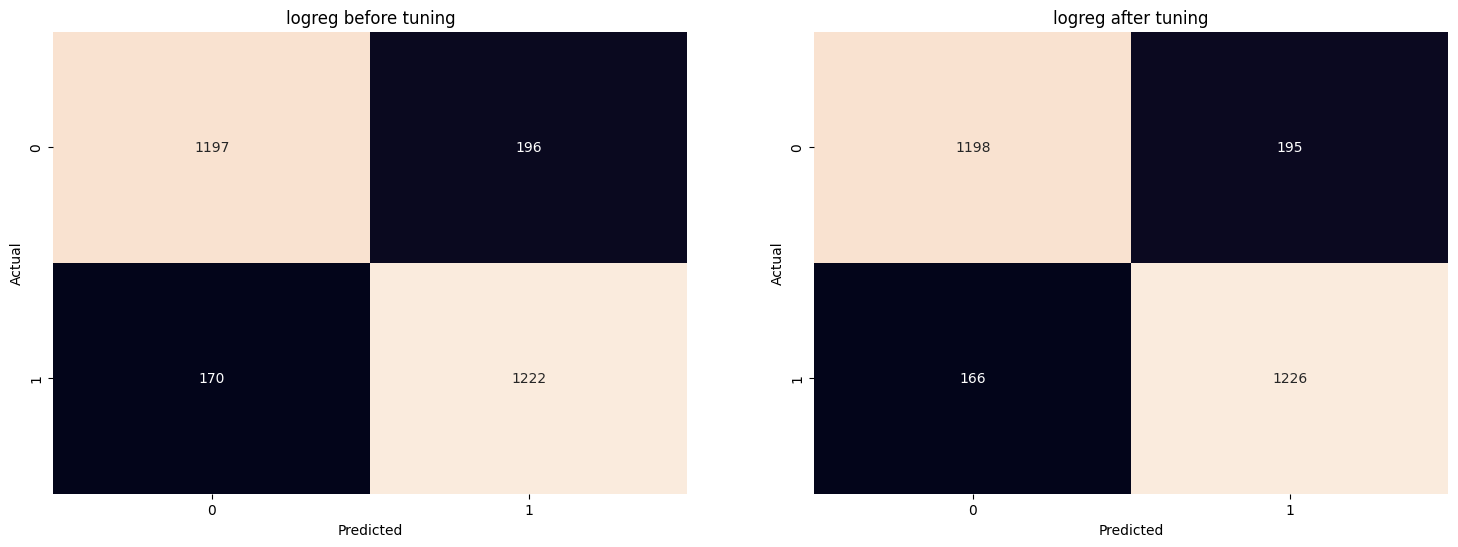

In [22]:
#Confusion Matrix before vs after tuning

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='.0f', ax=axes[0], cbar=False)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('logreg before tuning')

cm2 = confusion_matrix(y_test, y_pred_logreg_tuning, labels=logreg_tuning.classes_)
sns.heatmap(cm2, annot=True, fmt='.0f', ax=axes[1], cbar=False)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('logreg after tuning')



Confusion Matrix Analysis in test set.
- Before Tuning, model predicts True Positive of 1197 and False Positive of 1222, While incorrectly predict False Positive of 196 and 170 False Negative.
- After Tuning, model predicts True Positive increased by 1 (1198) and True Negative increased by 4 (1226). Also prediction for False Positive decreased 1 to 195 and Falsne Negative to 166 (recorrect 4 misprediction)

#### Thus, Our model of Logistic regression after tuning will be chosen.

And this is how logistic regression works,

Logistic regression is a  method used for  classification, which means it's designed to predict the probability that an instance belongs to a particular category, first it conducted problem formulation, to find relationship between independent variable to probability. Next, it has sigmoid function as a base alhoritm to predict the probability of a classification variable. Then, it use linear combination regarding its coefficient or weight. The probability result, if it is greater than equal 0.5, the preidcted instance going to positive class. Then in training phase, model will adjust to the weight to minimize difference between predicted probability and actual outcomes. Finally the model will optimize by gradient descent (iterative optimization algorithm for finding the local minimum of a function) in order to represent goodness of model prediction.

---
# 3.5.Model Interpretation
---

In this phase, we will interpret the model to gain a deeper understanding and insights. The interpretation will be presented in the form of 'feature importance' and 'lime tabular'.
- The purpose of feature importance is to identify which features have an impact on the deposit term decision.
- The influential features can be further explored to provide recommendations and business solutions related on our business context
- Since the resample data and model result is sufficient, feature selection is not necessary, and we can examine a few features that have the highest impact on deposit.
- Lime tabular is used to provide interpretation based on a specific data example, explaining its influence on target, whether from numeric or categorical features.

---

### - Feature Importance

In [23]:
#Define our best chosen model, logreg with hyperparameter tuning
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(cols=['education'],
                                                                 mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
professional.course    6
university.degree      7
dtype: int64}]),
                                                  ['education']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   Rob...
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed', 'duration']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 LogisticRegression(C=5.0, max_iter=1000, penalty='l1',
                                    random_state=42, solver='saga'))])

In [24]:
#See feature in numeric coefficient
coefficients = best_model['model'].coef_
coefficients

array([[ 0.02106184,  0.08485846, -0.09074032,  0.06959362, -0.11846741,
        -6.69759684,  3.05142051,  0.30414699,  2.04039187,  2.64200367,
        -0.37463667, -0.16705603, -0.18146667, -0.18015026,  0.03140593,
         0.14896189, -0.24686501, -0.26703754,  0.07762188,  0.01780975,
        -0.10706539, -0.00938001,  0.        ,  0.23554956, -0.33484166,
         0.        , -0.00810075, -0.46754643,  0.88432808,  0.33849285,
         0.01143078, -1.00595151,  2.39019127, -0.85894111, -0.57040202,
         0.14359323,  0.40010205, -0.05815702, -0.04461663,  0.07359432,
         0.19068742,  0.33154947,  1.61956944]])

In [25]:
#Extract feature name in model
best_model.named_steps['preprocess'].get_feature_names_out()

array(['ordinal__education', 'numeric__age', 'numeric__campaign',
       'numeric__pdays', 'numeric__previous', 'numeric__emp.var.rate',
       'numeric__cons.price.idx', 'numeric__cons.conf.idx',
       'numeric__nr.employed', 'numeric__duration',
       'categorical__job_blue-collar', 'categorical__job_entrepreneur',
       'categorical__job_housemaid', 'categorical__job_management',
       'categorical__job_other', 'categorical__job_retired',
       'categorical__job_self-employed', 'categorical__job_services',
       'categorical__job_student', 'categorical__job_technician',
       'categorical__job_unemployed', 'categorical__marital_married',
       'categorical__marital_other', 'categorical__marital_single',
       'categorical__default_other', 'categorical__housing_other',
       'categorical__housing_yes', 'categorical__contact_telephone',
       'categorical__month_aug', 'categorical__month_dec',
       'categorical__month_jul', 'categorical__month_jun',
       'categorical__m

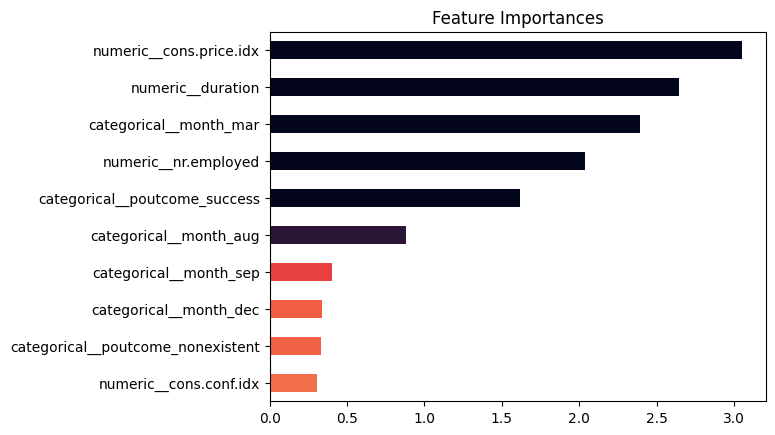

In [26]:
#Create graph for feature Importance
import matplotlib.cm as cm


coef = best_model['model'].coef_[0]
feature_names = best_model.named_steps['preprocess'].get_feature_names_out()

feature_importance = pd.Series(coef, index=feature_names).sort_values(ascending=False).head(10)
feature_importance = feature_importance.iloc[::-1]  # Reverse the order for better visualization

cmap = cm.get_cmap('rocket_r')
feature_importance.plot(kind='barh', title='Feature Importances', color=cmap(feature_importance))
plt.show()


As we can see here, 

- Numeric_cons.price.idx or cunsomer price index, importance value of 3.0 suggests that feature has a significant impact on the model's predictions, (whether deposit or not)

- Numeric duration is postive 2.0, which means, the longer the duration will increase likely customer to deposit. It can be interpreted that longer duration means customer will seek a lot of information to the campaigners, because they attracted to the campaign.

- categorical column month, positive value means there is an impact decision on month march.
- categorical column nr_emplyed, positive value of 2.0 means this feature has influence/importances toward target
- categorical column poutcome success, positive value and success, means the previous client that has been given previous campaign, and bank successfully attracted them in previous campaign, could be interpreted that they have a 'trust' and 'satisfactio' toward this bank.

### - Lime Tabular

the purpose of Lime is to provide faithful and interpretable explanations for individual predictions.

In [27]:
#library lime
import lime
from lime import lime_tabular

In [28]:
#train data for lime
X_train_transform = transformer.fit_transform(X_train)
X_train_cols = [i.split('__')[1] for i in transformer.get_feature_names_out()]
X_test_transform = transformer.transform(X_test)

logreg_model = LogisticRegression(random_state=42)

logreg_model.fit(X_train_transform, y_train)

LogisticRegression(random_state=42)

In [29]:
# lime function
explainer = lime_tabular.LimeTabularExplainer(
    training_data= X_train_transform,
    feature_names= X_train_cols,
    class_names= [0, 1],
    mode= 'classification'
)

(Previously, the default theme of the Lime library is dark and cannot be changed, and its colors may clash if our jupyter notebook environment is also dark.)

In this tabular view, we can observe and predict the likelihood of one customer to deposit or not. It will show the probabilities of churn or not, as well as the factors/features influencing that decision. We will take two examples, namely a customer predicted to deposit and another predicted not to deposit.

In [30]:
#visualisation
exp = explainer.explain_instance(
    data_row = X_test_transform[36], #index client (randomly input)
    predict_fn = logreg_model.predict_proba
)
exp.show_in_notebook(show_table=True)

Example one, based on the model, customer at index 212 has an 85% chance of making deposit. We can see that some features indeed support them to do deposit. For example, they have positive value for long duration for call and also when the cpi is positive (higher than other) as well. 

In [31]:
#visualisation
exp = explainer.explain_instance(
    data_row = X_test_transform[9], #index client (randomly input)
    predict_fn = logreg_model.predict_proba
)
exp.show_in_notebook(show_table=True)

Example two, based on the model, customer at index 9 has an 94% chance of not want to deposit. We can see that some features indeed support them to not do a deposit. For example, they have negative value for duration for call and also when the cpi is 0. 

 ---
# 4. Analysis, Conclusion and Reccommendation
---

# - Analysis

Thus, we will rephrase key points from our introduction.

0: Customers unlikely to subscribe to a term deposit.

1: Customers likely to subscribe to a term deposit.

- Type I error: FP (False Positives)

We predict the customers will subscribe term deposit, but in reality, they DON'T. The consequences here is the bank will waste time and money by conducting campaigns for the wrong customers, as tele-marketing cost per person is 3.12 euros, the bank will waste 3.12 euros from each miss-prediction. 

- Type II error: FN (False Negatives)
We predict the customers will NOT subscribe term deposit, but in reality, they DO. The consequences here is the bank will create a bank's negative impression by not providing them a proper campaign, which can lead to worsening the relationship with customers. But in FN there are no losses incurred in terms of time, money, or potential declines in net interest income. In fact, the bank stands to benefit from this situation.

Then we check the confussion matrix

Text(0.5, 1.0, 'logreg after tuning')

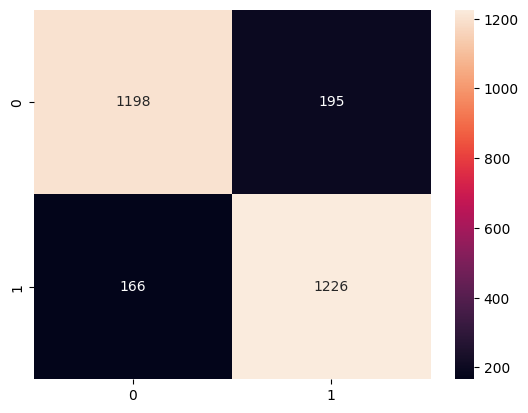

In [32]:
plt.subplots
cm2 = confusion_matrix(y_test, y_pred_logreg_tuning, labels=logreg_tuning.classes_)
sns.heatmap(cm2, annot=True, fmt='.0f')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('logreg after tuning')

From the introduction before, we calculate the cost of telemarketing campaign which around 3.12 euros,
- TP, prediction customer who decide to deposit and actual is doing deposit = 1226
- TN, prediction customer who's not doing deposit and real actual they indeed not doing deposit = 1198
- FP, predict customer who's deposit but actually they don't do deposit = 195
- FN, predict customer is not doing deposit but indeed they are deposit = 166.
- Total = 2785

Scenario 1: Without Machine Learning
- If we are not using machine learning, we tend to give campaign and spending tele-marketing cost to all of the target.
- Which means = 2785 x 3.12 = 8698.2 euros, total of tele-marketing campaign cost.

Scenario 2: Using Machine Learning
- If we find out the customer who will do deposit, we will give marketing campaign to that exclusively to that people only.
- If we find out the customer who will not do deposit, then we will not spending telemarketing campaign cost to that customers.
- For false negatives in this case, there are 166 instances. However, we are actually benefited by not running a campaign, as it turns out they made a deposit.
- For false positives, there are 195 instances of incorrect predictions. We mistakenly predicted that they would make a deposit, but in reality,
- Thus using machine learning, we only spend (1226+195) *3.12 euros = 4433,2 euros.

Or we can save 4264 euros, 48,9 percent from total of marketing campaign cost

### - Model Limitation



- Our original dataset does not have 'balance' or 'deposit revenue', we think it will be more optimize to analyze whether in analytic or modelling if we can have that feature.
- Our model using stratisfied sample by strata age feature, eventhough the sample is representative of its population by validating from statistical method, there maybe a better implementation using another strata, or even combining external resources.
- We use 7 models, excluding voting and stacking classifier model.
- We only iterate one hyperparameter tuning from logistic regression (from the best model benchmarking that we got)

## - Conclusion

Let see our goals from our business understanding from introduction before.

1. Understand customer behavior patterns and demographics based on their personal data, previous history campaign, socio-economic factor, correlation and draw its conclusion.
2. Building a predictive model that accurately predicts customer behavior, helping the bank focus its telemarketing efforts on individuals more likely to subscribe to a term deposit.
3. Improving efficiency by reducing the telemarketing cost based on model developed.


For Answering number 1, we can see from analytic method derived from our EDA analysis in chapter 2.

Personal Client Data,
- Job, student, admin, technicians and retired inidviduals 
- Education level, higher education degree such as university degree and professional course graduated.
- Marital Status, the bank may outreach toward single individual.
- For age itself, the bank may focus on older people (>65 years old) followed by younger people (17-25 age range)

Campaign Method and History
- Contact Method, reach customer toward cellular phone users.
- Period, focused on contacting during period December and March. For day of week, it preferred on wednesday.
- For duration called, encourage to invest in more time talking with potential client.
- For Campaign itself, the bank need to saturate their frequency campaign in order to not annoying potential customer.
- Rgearding Client who has been given campaign before, it suggest that this group more likely to doing another deposit, probably because their well-defined experience toward this bank.

Financial Status
- Housing loan,  The customer who has housing loan indicates want to do deposit.
- Default, When customer has default history, they tend not to do deposit, probably due their poor credit score.

Socio-Economic Factor,
- Consumer Price Index and employment rate indicator, when those rate are lower, client tends to do deposit. This is might be because the behaviour when there is a slightly external factor crisis, they have tendency to make a saving.
- Consumer Confidence Index, when those rate are higher, customer tend to do deposit because the liquidity during this time of economic is advantegous.

For goals 2, we can see from predictive model, we can take the main points from our feature importance. And we relate toward behaviour that derived from goal of number 1 (EDA),

- CPI (Consumer Price Index), while it is an external factor, customer has tendency to make deposit or not when the inflation level fluctuated, this is the most consideration factor from our model. Based on EDA analysis, the lower the CPI rate the more people will make a deposit.

- For numeric duration, it suggests that longer period, the more inclined client to make deposit, by longer duration customer will gain a lot of information from the campaign promotion itself.

- Customer has tendency to deciding to make deposit in month march, august, september and december. This pattern inline with our EDA which recommend in month March. 

- Customer also inclines to make a deposit when employment rate is lower.

- When customer has been given campaign before and the campaign is successful, they have a leaning toward making a deposit.

For Goal number 3 of Effieciency Analysis, as we defined from confusion matrix from our model. Which we only spend (1226+195) client targeted * 29 euros or 41.209 euros. It can save 48.9% of marketing budget cost will improve our efficiency.

## - Recommendation

We will breakdown reccomendation into three perspective, from business context, model and dataset.

### 1. Business Context
- Leveraging social-economic factors: Pay close attention to Portugal's economic climate, particularly the Consumer Price Index (CPI) and employment rate. When these factors are favorable, customers tend to be more open to making deposits.

- Sharpen negotiation skills: Equip campaigners with the necessary persuasion tactics to effectively convince clients to take the plunge and commit to a deposit. The longer the customer get insight the more inclined they will make a deposit

- Prioritize existing relationships from previous successful campaign: Actively target clients you've built strong connections with in the past. Maintaining positive reportt can be the deciding factor in persuading tooward their deposit.

- Embrace seasonality: bank need to understand the unique spending patterns throughout the year in Portugal. Leverage this knowledge to targeted marketing campaigns and service offerings at the most opportune times as from this analysis is month of March.

### 2. Model Context

- The best model is logistic regression but not limited to other models such as XGB and Catboost, had the bank want to use our model, it reccommended to maintain the modelling itself and compare to other model, especially when there is a new dataset.
- For hyperparameter tuning, it reccommends to do several times.
- We recommend also to do other configuration in parameter of hyperparameter tuning
- We also recommend for further research to do feature selection such as wrapper or ensemble methods.

### 3. Dataset Context
- For further research, it may need other features such as client's balance or deposit revenue.
- The original dataset has extreme imbalance nature, therefore, it may need to add class minority value into the target of the original dataset.

# ======Thank You Very Much=====

Best Regard:

Nilam Ayu Rosari

Novaldi Halomoan

JCDS03 Batam

In [33]:
import pickle

# Save Model
filename = 'model_alpha_batam_campaign.sav'
pickle.dump(logreg_tuning, open(filename, 'wb'))

---